<a href="https://colab.research.google.com/github/Alex-5551/Agric-Trust/blob/main/agriTrust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

In [112]:
raw_data = pd.read_csv("/content/drive/MyDrive/A2F_2023_Revised.csv")
raw_data.head()

<ipython-input-112-0410ec5258b2>:1: DtypeWarning:

Columns (42,98,134,136,158,186,208,216,220,533,682,683,684,686,687,688,690,692,693,694,695,696,697,743,771,832,849,858,871,886,908,921,929,955,957,962,963,974,984,989,990,1001,1003,1012,1013,1015,1016,1018,1029,1032,1040,1041,1043,1044,1046,1069,1070,1085,1088,1099,1113,1130,1140,1146,1180,1210,1213,1215,1220,1239,1254,1268,1288,1291,1307,1318,1333,1353,1364,1376,1398,1450,1538) have mixed types. Specify dtype option on import or set low_memory=False.



,statecode,state_code,e6,state,agegroup,respondent_serial,Weightingvariable,final_hh_wgt,region,state_name,...,finneeds_transferofvalue,target_groups,savings_group,cooperative,village_comm_association,savings_thrift,microfinance,money_lender,finhealth_indicator_final,finlit_cap_final
0,1.0,31.0,2.0,ABIA,2.0,3697287.0,686.992065,749.888855,2.0,ABIA,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0
1,1.0,31.0,2.0,ABIA,2.0,3546312.0,1292.105957,1028.419067,2.0,ABIA,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0
2,1.0,31.0,1.0,ABIA,2.0,3737095.0,274.308411,492.784119,2.0,ABIA,...,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,1.0,31.0,1.0,ABIA,2.0,3545118.0,1194.719360,1028.419067,2.0,ABIA,...,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
4,1.0,31.0,1.0,ABIA,2.0,3705829.0,4107.366211,1906.860229,2.0,ABIA,...,1.0,4.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [113]:
raw_data.shape

(28392, 1613)

In [114]:
raw_data.shape

(28392, 1613)

## Data Exploration

In [115]:
## A function to wrangle data
def wrangle(filepath):

    #read data into pandas dataframe
    raw_df = pd.read_csv(filepath)

    #subset to youths. Age: 18 to 25
    df = raw_df.query('(e7>=18) and (e7<=25)')

    #select relevant columns
    cols = ["state", "sector", "finhealth_resilience", "finhealth_access", "lc1_2","finhealth_indicator_final", "cc1_3", "cc1_6",
        "finlit_knowledge", "e7", "e8","ie1b","lc1_1", "lc1a", "gen3_1", "banked", "e13a_1", "e14_17", "e14_15", "e14_3","e6",
        "gen3_7", "insurance_strand", "e14_11", "credit_strand", "saving_strand","investments_physical_assets", "investments_capital_markets", "f5b"]
    drop_cols = [col for col in df.columns if col not in cols]
    df = df.drop(columns = drop_cols)

   #drop missing rows subsetting by secctor of work(e13a_1, individuals who work in Agriculture, forestry & fishing) and debt(lc1a, level of debt)
    df = df.dropna(subset=["lc1a", "e13a_1"])

    #convert from float to integer. Example age can't be float
    for col in df.columns:
        if df[col].dtype == "float":
            df[col] = df[col].astype("int")
        else:
           df[col] = df[col].astype("object")

    # change the ranking of some feature, to avoid the model giving two weight to them( scaling)
    # 99 = not insured, 1 = insured

    insure_dict = {99:0, 1:1}

    df["insurance_strand"] = df["insurance_strand"].replace(insure_dict)


    save_dict = {1:1, 2:2, 3:3, 4:4, 99:0}
    df["saving_strand"] = df["saving_strand"].replace(save_dict)

    #rename columns
    df.rename(columns={
        "e7":"Age",
        "e14_3":"Voters_card",
        "e8": "Edu_level",
        "e14_11": "BVN",
        "e14_15": "Tax_invoice",
        "e14_17":"Tax_cert",
        "f5b": "invest_freq",
        "lc1_1": "Borrowed_in_past",
        "lc1_2": "Paying_borrowed",
        "ie1b":"Avg_income",
        "gen3_1": "Own_agri_land",
        "gen3_7": "Own_agri_mech_tool",
        "e6": "Gender",
        "cc1_3": "Drought_damage",
        "cc1_6": "Pest_infestation",
        "e13a_1": "workin_agri_forestry_fishing",
        "lc1a": "Debt"
    }, inplace = True)


    # reset index
    df  = df.reset_index(drop = True)

    return df


In [116]:
df = wrangle("/content/drive/MyDrive/A2F_2023_Revised.csv")

df.head()

<ipython-input-115-d983f4e8a230>:5: DtypeWarning:

Columns (42,98,134,136,158,186,208,216,220,533,682,683,684,686,687,688,690,692,693,694,695,696,697,743,771,832,849,858,871,886,908,921,929,955,957,962,963,974,984,989,990,1001,1003,1012,1013,1015,1016,1018,1029,1032,1040,1041,1043,1044,1046,1069,1070,1085,1088,1099,1113,1130,1140,1146,1180,1210,1213,1215,1220,1239,1254,1268,1288,1291,1307,1318,1333,1353,1364,1376,1398,1450,1538) have mixed types. Specify dtype option on import or set low_memory=False.



,Gender,state,sector,Age,Edu_level,workin_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,...,banked,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final
0,2,ABIA,1,25,4,0,1,2,2,2,...,2,3,4,0,1,2,2,0,2,1
1,1,ABIA,1,25,5,0,1,1,2,2,...,1,1,3,0,2,2,0,2,2,1
2,2,ABIA,1,23,5,0,1,2,2,2,...,1,1,4,0,1,2,1,0,2,1
3,1,ABIA,1,23,5,0,1,1,2,2,...,1,1,4,0,1,2,0,0,2,0
4,1,ADAMAWA,2,25,5,1,1,1,2,2,...,2,0,4,0,1,2,0,0,0,1


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        1055 non-null   int64 
 1   state                         1055 non-null   object
 2   sector                        1055 non-null   int64 
 3   Age                           1055 non-null   int64 
 4   Edu_level                     1055 non-null   int64 
 5   workin_agri_forestry_fishing  1055 non-null   int64 
 6   Voters_card                   1055 non-null   int64 
 7   BVN                           1055 non-null   int64 
 8   Tax_invoice                   1055 non-null   int64 
 9   Tax_cert                      1055 non-null   int64 
 10  invest_freq                   1055 non-null   int64 
 11  Borrowed_in_past              1055 non-null   int64 
 12  Paying_borrowed               1055 non-null   int64 
 13  Debt              

In [118]:
print(df.shape)
df.describe()

(1055, 29)


,Gender,sector,Age,Edu_level,workin_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,...,banked,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,...,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,1.574408,1.563033,22.437915,5.745972,0.458768,1.370616,1.575355,1.981043,1.981043,2.400948,...,1.516588,1.428436,3.700474,0.021801,1.433175,1.941232,0.527014,0.224645,0.968720,0.816114
std,0.494667,0.496246,2.402498,2.690894,0.498533,0.483199,0.494523,0.136439,0.136439,0.641245,...,0.499962,1.470890,0.645632,0.146102,0.495749,0.235301,0.760118,0.484836,0.898009,0.625461
min,1.000000,1.000000,18.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,20.000000,4.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,...,1.000000,0.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,23.000000,5.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,2.000000,2.000000,25.000000,6.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,...,2.000000,3.000000,4.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,1.000000
max,2.000000,2.000000,25.000000,11.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,...,2.000000,4.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


## Data Visualization

uncoding categorical features


In [119]:
# encoding of categorical variables for visualization
gender = df["Gender"].replace({1: "Male", 2: "Female"})


#own Agricultural land
own_agri=  df["Own_agri_land"].replace({1:"Own(in my name)",
                                        2:"Joint ownership",
                                        3:"Do no own"})


#Agricultural mechanical tools
mech_agri = df["Own_agri_mech_tool"].replace({
                                              1:"Own(in my name)",
                                              2:"Joint ownership",
                                              3:"Do no own"})

# Highest level of education
edu_level = df["Edu_level"].replace({1:"Pre-school",
    2: "Primary incomplete ",
    3:"Primary complete",
    4:"Secondary incomplete",
    5:"Secondary complete",
    6:"University/Polytechnic OND",
    7:"University/Polytechnic HND",
    8:"Post-university incomplete",
    9:"Post-university complete",
    10:"Non-formal education (e.g., Arabic/Quranic education)",
    11:"No education" })

#Income level
income_dict = {
    1:"Below N15,000 per month",
    2: "N15,001 - N35,000 per month",
    3:"N35001 - N55,000 per month",
    4: "N55,001 - N75,000 per month",
    5: "N75,001 - N95,000 per month",
    6: "N95,001 - N115,000 per month",
    7: "N115,001 - N135,000 per month",
    8: "N135,001 - N155,000 per month",
    9: "N155,001 - N175,000 per month",
    10: "N175,001 - N195,000 per month",
    11: "N195,001 - N215,000 per month ",
    12: "N215,001 - N235,000 per month",
    13: "N235,001 - N255,000 per month",
    14: "N255,001 - 275,000 per month",
    15: "N275,001 - 295,000 per month",
    16: "N295,001 - 315,000 per month",
    17: "Above N315,000 per month",
    18: "Refused",
    19: "Don't Know",
    20: "No income"
}

income_level = df["Avg_income"].replace(income_dict)

#saving strand, where indivduals save there money
save_strand = df["saving_strand"].replace({1:"bank",
                    2: "non_formal bank channels",
                    3:"Informal mechanisms",
                    4: "At home",
                    0: "No saving"})

#insurance strand: An indicator that separates the population of a country into those who are insured and those who are not
insurance = df["insurance_strand"].replace({1:"Insured",
                                           0:"Not insured"})

#Finlit_knowledge: Individuals who have awareness, understanding, and familiarity with financial concepts, products
fin_know = df["finlit_knowledge"].replace({0:"Low",
                                           1:"Moderate",
                                           2: "High"})
#fin_health indicator: An indicator that separates the population of a country into those who are financially healthy
#from those who are financially vulnerable
fin_indicator = df["finhealth_indicator_final"].replace({0:"Low(Financially Vulnerable)",
                                           1:"Moderate(Financially Coping)",
                                           2: "High(Financially Healthy)"})
#Experienced pest infestation
pest = df["Pest_infestation"].replace({1: "Yes", 2: "No"})
#Experienced Drought
drought = df["Drought_damage"].replace({1: "Yes", 2: "No"})

#Debt
debt = df["Debt"].replace({1: "Do not have any debt",
  2: "Have a manageable amount of debt",
  3: "Have a bit more debt than is manageable",
  4: "Have far more debt than is manageable"})

sector_df = df["sector"].replace({1: "urban", 2: "rural"})

In [120]:
# Distributions
rural = sector_df.value_counts(normalize = True).iloc[0]
urban = sector_df.value_counts(normalize=True).iloc[1]
print(f"The proportion of youths in the rural sector is {rural: .1%}")
print(f"The proportion of youths in the urban sector is {urban: .1%}")

gender_count = gender.value_counts(normalize=True)
print(f"\nThe percentage of female youths is {gender_count.iloc[0]: .1%}")
print(f"The percentage of female youths is {gender_count.iloc[1]: .1%}")

indicator_count = fin_indicator.value_counts(normalize=True).sort_values()
print(f"\nThe percentage of financially venurable youths: {indicator_count.iloc[0]: .1%}")
print(f"The percentage of  financially coping youths: {indicator_count.iloc[1]: .1%}")
print(f"The percentage of  financially healthy youths: {indicator_count.iloc[2]: .1%}")

The proportion of youths in the rural sector is  56.3%
The proportion of youths in the urban sector is  43.7%

The percentage of female youths is  57.4%
The percentage of female youths is  42.6%

The percentage of financially venurable youths:  12.0%
The percentage of  financially coping youths:  30.4%
The percentage of  financially healthy youths:  57.5%


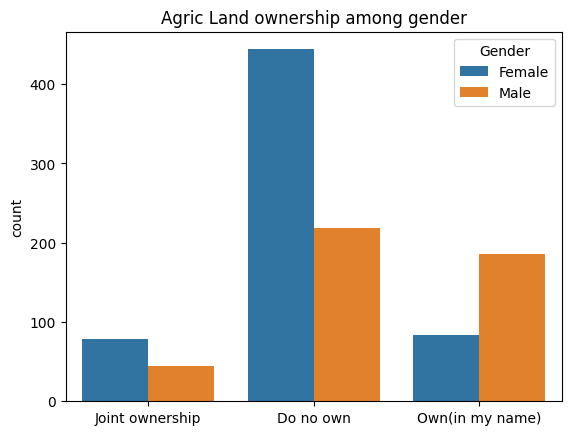

In [121]:
sns.countplot(df, x =own_agri,hue = gender)
plt.title("Agric Land ownership among gender")
plt.xlabel("");

In [122]:
fig = px.bar(save_strand.value_counts(normalize =   True), title = "Saving strand Among Youths")
fig.show()

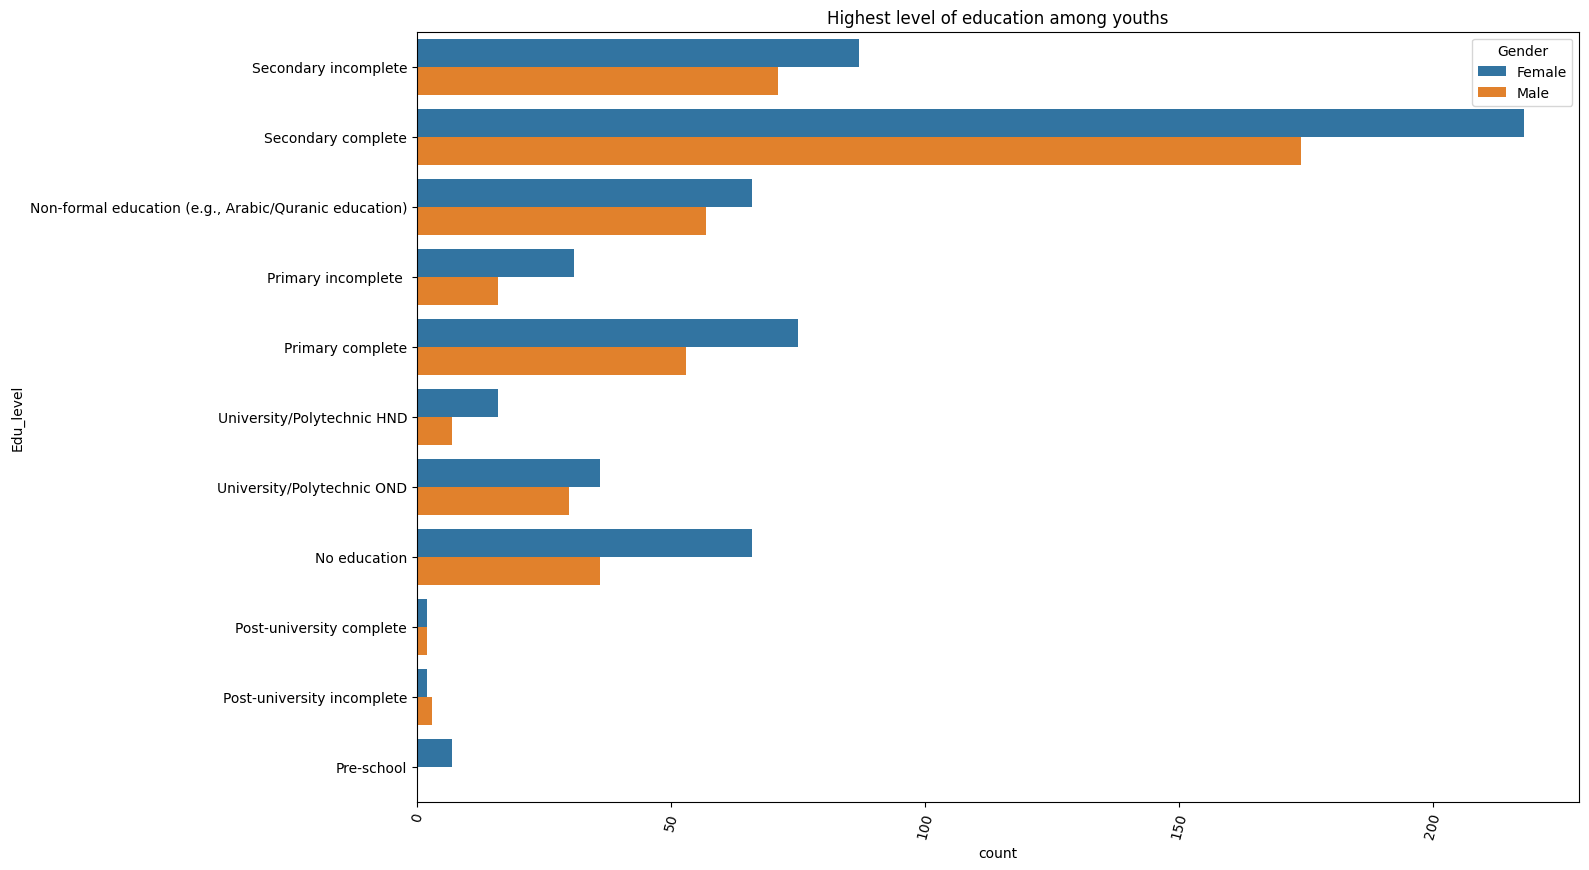

In [123]:
fig = plt.figure(figsize = (15,10))
sns.countplot(y=edu_level, hue = gender)
plt.xticks(rotation = 75)
plt.title("Highest level of education among youths");

In [124]:
fig = px.bar(save_strand, facet_col = gender, color = fin_know, title = "Finanacial knowledgeable youths vs Approach to saving")
fig.show()

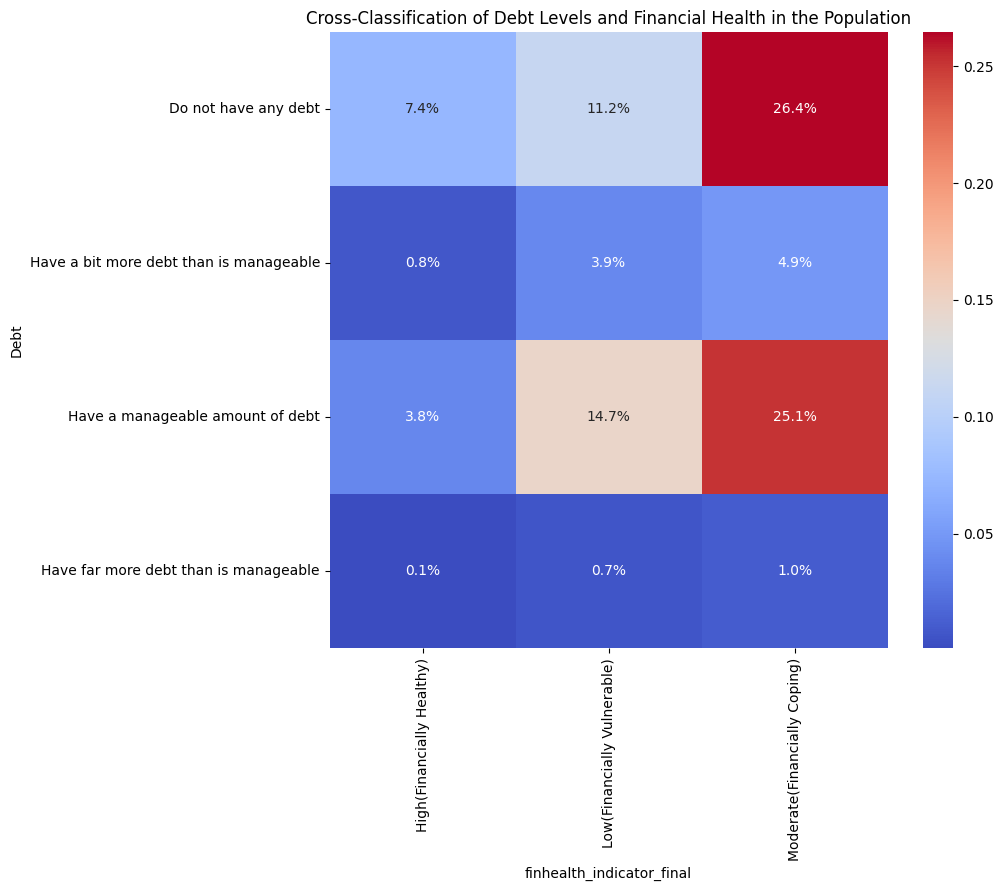

In [125]:
ct = pd.crosstab(index = debt, columns = fin_indicator)
ct_pct = ct/ct.values.sum()

fig = plt.figure(figsize = (9,8))
sns.heatmap(ct_pct, annot = True, cmap = "coolwarm", fmt = ".1%")
plt.title("Cross-Classification of Debt Levels and Financial Health in the Population");

97.8% OF YOUTHS DOESN'T HAVE INSURANCE

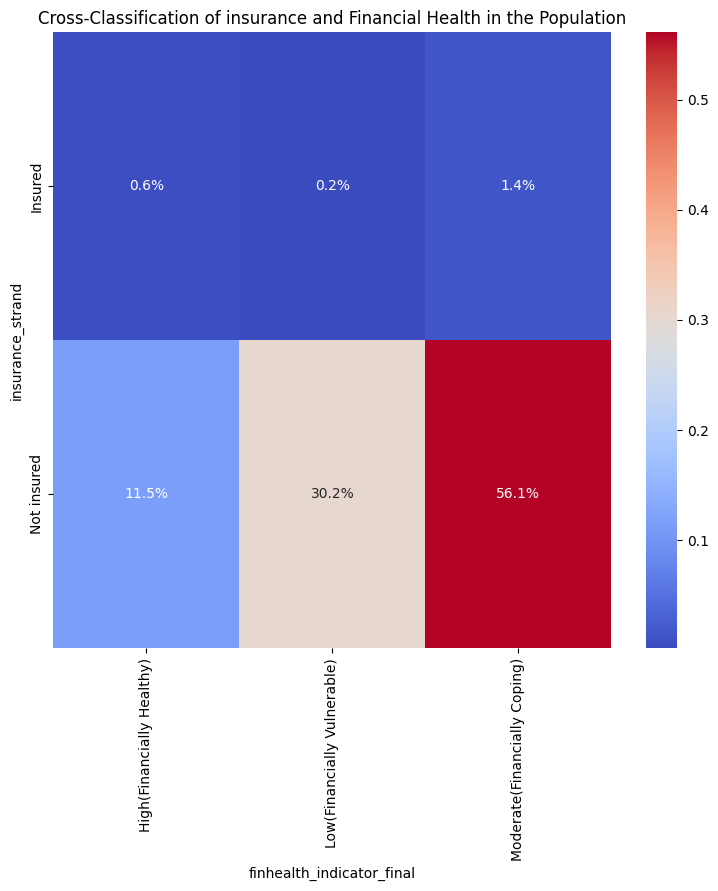

In [126]:
ct = pd.crosstab(index = insurance, columns = fin_indicator)
ct_pct = ct/ct.values.sum()

fig = plt.figure(figsize = (9,8))
sns.heatmap(ct_pct, annot = True, cmap = "coolwarm", fmt = ".1%")
plt.title("Cross-Classification of insurance and Financial Health in the Population");

In [127]:
df_var = df.drop(columns = "state")
df_var.var().sort_values(ascending = False)

,0
Avg_income,35.367048
Edu_level,7.240911
Age,5.771996
saving_strand,2.163517
finlit_knowledge,0.806421
Own_agri_land,0.744646
finhealth_resilience,0.577780
Debt,0.517068
credit_strand,0.416840
invest_freq,0.411195


## Building of Model
1. VAE model is utilized  due to its ability to handle high-dimensional, mixed-type data while capturing complex latent patterns.

In [128]:
X  = df.copy("deep")
X = df.drop(columns = "state")
X.head()

,Gender,sector,Age,Edu_level,workin_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,...,banked,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final
0,2,1,25,4,0,1,2,2,2,2,...,2,3,4,0,1,2,2,0,2,1
1,1,1,25,5,0,1,1,2,2,2,...,1,1,3,0,2,2,0,2,2,1
2,2,1,23,5,0,1,2,2,2,1,...,1,1,4,0,1,2,1,0,2,1
3,1,1,23,5,0,1,1,2,2,3,...,1,1,4,0,1,2,0,0,2,0
4,1,2,25,5,1,1,1,2,2,2,...,2,0,4,0,1,2,0,0,0,1


In [129]:
# Parameters
input_dim = X.shape[1]
latent_dim = 2

# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, x):
        h = self.dense1(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z, z_mean, z_log_var

# Decoder
class Decoder(Model):
    def __init__(self, input_dim):
        super().__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(input_dim)

    def call(self, z):
        h = self.dense1(z)
        return self.out(h)

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        z, z_mean, z_log_var = self.encoder(x)
        reconstructed = self.decoder(z)
        # Add KL and reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstructed))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

# Build and train
encoder = Encoder(latent_dim)
decoder = Decoder(input_dim)
vae = VAE(encoder, decoder)

vae.compile(optimizer='adam')
vae.fit(X, X, epochs=30, batch_size=32)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 30.3785
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.9883
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2377
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0215
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8668
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0372
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4587
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6933
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5717
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7787
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5986
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3485
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0293
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7480
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5487
Epoch 16/30
3

In [130]:
z, _, _ = encoder(X)
latent_space = z.numpy()

## Kmeans Clustering using the latent space from the VAE

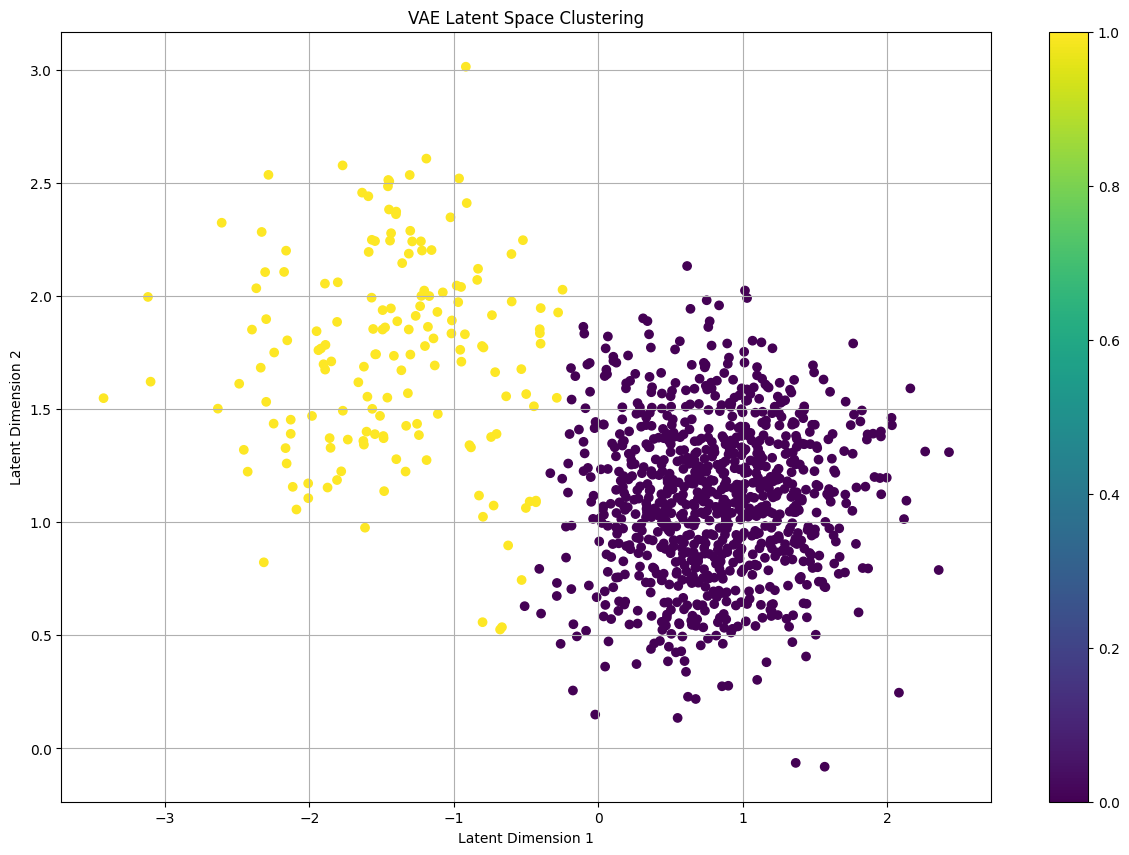

In [131]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init = 10, random_state=42) # two clusters are needed, individuals who are creditworthy or not
cluster_labels = kmeans.fit_predict(latent_space)

# Visualize
plt.figure(figsize=(15,10))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=cluster_labels, cmap='viridis')
plt.title("VAE Latent Space Clustering")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.colorbar()
plt.show()

In [132]:
score = silhouette_score(latent_space, cluster_labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.6538


In [133]:
# Assign cluster labels to original data to be used for classification
X["cluster"] = cluster_labels
X.head(10)

,Gender,sector,Age,Edu_level,workin_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,...,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,cluster
0,2,1,25,4,0,1,2,2,2,2,...,3,4,0,1,2,2,0,2,1,0
1,1,1,25,5,0,1,1,2,2,2,...,1,3,0,2,2,0,2,2,1,0
2,2,1,23,5,0,1,2,2,2,1,...,1,4,0,1,2,1,0,2,1,0
3,1,1,23,5,0,1,1,2,2,3,...,1,4,0,1,2,0,0,2,0,0
4,1,2,25,5,1,1,1,2,2,2,...,0,4,0,1,2,0,0,0,1,0
5,1,2,22,5,1,1,2,2,2,3,...,0,4,0,2,2,0,0,2,1,0
6,1,2,20,4,1,1,2,2,2,1,...,0,4,0,1,2,1,0,1,1,0
7,1,1,22,5,1,1,2,2,2,2,...,0,4,0,1,2,0,0,2,0,0
8,1,2,25,10,1,2,1,2,2,2,...,0,4,0,1,2,0,0,0,1,1
9,1,2,25,2,1,1,2,2,2,3,...,0,4,0,1,2,0,0,0,0,0


In [134]:
cluster_summary = X.groupby("cluster").mean()

In [135]:
cluster_summary = X.groupby("cluster").mean()

fig = px.bar(cluster_summary, barmode = "group")
fig.show()

## classification using the clusters

In [136]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score

In [137]:
df_work = X.copy("deep")

In [138]:
df_work.head()

,Gender,sector,Age,Edu_level,workin_agri_forestry_fishing,Voters_card,BVN,Tax_invoice,Tax_cert,invest_freq,...,saving_strand,credit_strand,insurance_strand,investments_physical_assets,investments_capital_markets,finhealth_resilience,finhealth_access,finlit_knowledge,finhealth_indicator_final,cluster
0,2,1,25,4,0,1,2,2,2,2,...,3,4,0,1,2,2,0,2,1,0
1,1,1,25,5,0,1,1,2,2,2,...,1,3,0,2,2,0,2,2,1,0
2,2,1,23,5,0,1,2,2,2,1,...,1,4,0,1,2,1,0,2,1,0
3,1,1,23,5,0,1,1,2,2,3,...,1,4,0,1,2,0,0,2,0,0
4,1,2,25,5,1,1,1,2,2,2,...,0,4,0,1,2,0,0,0,1,0


In [139]:
# split data into feature matrix and target vectot
target = "cluster"
X = df_work.drop(columns = target, axis = 1)
y = df_work[target]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

##Random Forest Classifier


In [140]:
#baseline model
acc_baseline = y_train.value_counts(normalize=True)
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: cluster
0    0.8495
1    0.1505
Name: proportion, dtype: float64


In [141]:
clf = RandomForestClassifier(random_state = 42)

params = {
    "n_estimators": range(25,100,25),
    "max_depth": range(10,50,10),
    "min_samples_split": range(2,10,2)
}

model = GridSearchCV(
    clf,
    param_grid = params,
    n_jobs = -1,
    cv = 5
)

model.fit(X_train, y_train)

best = model.best_params_
print(f"Best parameter:{best} ")
model_accuracy = model.score(X_test, y_test)
print(f"\nRandom forest classifier accuracy: {model_accuracy}")

Best parameter:{'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 75} 

Random forest classifier accuracy: 0.990521327014218


## Save model

In [142]:
import joblib

joblib.dump(model, 'model_rf.pkl')

['model_rf.pkl']

In [143]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       173
           1       1.00      0.95      0.97        38

    accuracy                           0.99       211
   macro avg       0.99      0.97      0.98       211
weighted avg       0.99      0.99      0.99       211



In [145]:
clf2 = GradientBoostingClassifier()

params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': range(10,50,10),
    "min_samples_split": range(2,10,2)
}

model2 = GridSearchCV(
    clf2,
    param_grid = params,
    n_jobs = -1,
    cv = 5
)

model2.fit(X_train,y_train)

model2_accuracy = model2.score(X_test,y_test)
print(f"Gradient Boosting Classifier accuracy: {model2_accuracy}")

Gradient Boosting Classifier accuracy: 0.985781990521327


In [146]:
y_pred = model2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       173
           1       0.97      0.95      0.96        38

    accuracy                           0.99       211
   macro avg       0.98      0.97      0.98       211
weighted avg       0.99      0.99      0.99       211



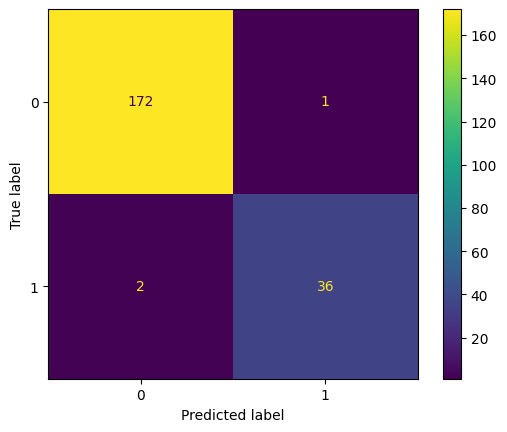

In [147]:

# # Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [148]:
importances = model.best_estimator_.feature_importances_

feature_importances = pd.Series(importances, index=X.columns)

# Sort
feature_importances = feature_importances.sort_values(ascending=False)

print(feature_importances)

Avg_income                      0.761406
Age                             0.029301
Edu_level                       0.018340
saving_strand                   0.017532
Pest_infestation                0.017437
Debt                            0.012355
finlit_knowledge                0.012300
invest_freq                     0.011341
finhealth_resilience            0.009304
finhealth_access                0.009234
Voters_card                     0.008818
Paying_borrowed                 0.008294
workin_agri_forestry_fishing    0.008209
Own_agri_land                   0.007801
finhealth_indicator_final       0.007652
sector                          0.007356
Drought_damage                  0.007135
BVN                             0.006993
credit_strand                   0.006746
investments_physical_assets     0.006365
Borrowed_in_past                0.006002
banked                          0.005687
investments_capital_markets     0.005465
Gender                          0.004862
Tax_cert        